In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os
import pandas as pd

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
listed = drive.ListFile({'q': "title contains 'train.zip' and '12YxbbpoPGa-4dUXq2BqFjERPBeh1T3qY' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title train.zip, id 1zRzgwnzMs52MN674v6TFDOMrKi1jg6dN


In [0]:
listed = drive.ListFile({'q': "title contains 'test_ApKoW4T.csv' and '12YxbbpoPGa-4dUXq2BqFjERPBeh1T3qY' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title test_ApKoW4T.csv, id 1Q-zq1KI5_O9edhQypA8NVIaPHSrMW7u1


In [0]:
listed = drive.ListFile({'q': "title contains 'sample_submission_ns2btKE' and '12YxbbpoPGa-4dUXq2BqFjERPBeh1T3qY' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title sample_submission_ns2btKE.csv, id 1nBXWv_NNGO-HkO0FUia84vbzsM-DBQyP


In [0]:
download_path = os.path.expanduser('/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

output_file = os.path.join(download_path, 'train.zip')

temp_file = drive.CreateFile({'id': '1zRzgwnzMs52MN674v6TFDOMrKi1jg6dN'})
temp_file.GetContentFile(output_file)

In [0]:
download_path = os.path.expanduser('/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

output_file = os.path.join(download_path, 'test_ApKoW4T.csv')

temp_file = drive.CreateFile({'id': '1Q-zq1KI5_O9edhQypA8NVIaPHSrMW7u1'})
temp_file.GetContentFile(output_file)

In [0]:
download_path = os.path.expanduser('/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

output_file = os.path.join(download_path, 'sample_submission_ns2btKE.csv')

temp_file = drive.CreateFile({'id': '1Q-zq1KI5_O9edhQypA8NVIaPHSrMW7u1'})
temp_file.GetContentFile(output_file)

In [0]:
cd /data

/data


In [0]:
!unzip train.zip -d /data

Archive:  train.zip
replace /data/images/2870091.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
ls

images/    sample_submission_ns2btKE.csv  test.csv   train.zip
__MACOSX/  test_ApKoW4T.csv               train.csv


In [0]:
!mv test_ApKoW4T.csv test.csv

In [0]:
cd images/

/data/images


In [0]:
cd ..

/data


In [0]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from skimage import io, transform
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import StratifiedShuffleSplit
import time
import copy
from tqdm import tqdm_notebook, tqdm, trange

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [0]:
transform = transforms.Compose([
    
    transforms.Normalize([0.5], [0.5]),
    transforms.Resize(32,32),
    transforms.ToTensor(),
    
    ])

In [0]:
class CustomDataset(Dataset):
  def __init__(self, labels_df, img_path, transform=None):
    self.labels_df=labels_df
    self.img_path=img_path
    self.transform=transform
    
  def __len__(self):
    return  len(self.labels_df)
  
  def __getitem__(self,idx):
    image_name=os.path.join(self.img_path, self.labels_df.image[idx])
    #img=io.imread(image_name)
    img=Image.open(image_name).convert('RGB')
    label=self.labels_df.category[idx]
    
    
    if self.transform:
      img=self.transform(img)
    return [img, label]  

In [0]:
data_root = '../data/'

In [0]:
dataframe = pd.read_csv('train.csv')

In [0]:
test=pd.read_csv('test.csv')

In [0]:
test['category']=[0]*len(test)

In [0]:
print(dataframe.head()), print(test.head())

         image  category
0  2823080.jpg         1
1  2870024.jpg         1
2  2662125.jpg         2
3  2900420.jpg         3
4  2804883.jpg         2
         image  category
0  1007700.jpg         0
1  1011369.jpg         0
2  1051155.jpg         0
3  1062001.jpg         0
4  1069397.jpg         0


(None, None)

In [0]:
dataframe['category']=dataframe['category'].map(lambda x: x-1)

In [0]:
!ls

images	__MACOSX  sample_submission_ns2btKE.csv  test.csv  train.csv  train.zip


In [0]:
batch_size=5
mean=[0.5, 0.5, 0.5]
std_dev=[0.5, 0.5, 0.5]
#mean=[0.485, 0.456, 0.406]
#std_dev=[0.229, 0.224, 0.225]
trans_vis=transforms.Compose([transforms.Resize(224),
                         transforms.RandomCrop(224),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         #transforms.Normalize(mean, std_dev)
                         ])


In [0]:
#train_ds=torchvision.datasets.ImageFolder(root='/data/', transform=trans_train)

In [0]:

vis_ds = CustomDataset(dataframe,os.path.join(data_root,'images'), transform=trans_vis)
len(vis_ds)

6252

In [0]:
visloader=DataLoader(vis_ds, batch_size=batch_size, shuffle=True)

In [0]:
def imshow(img, title):
    #npimg = img.numpy() #/ 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

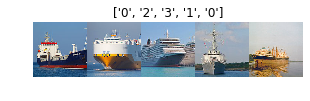

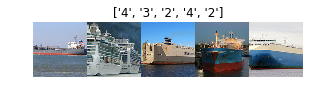

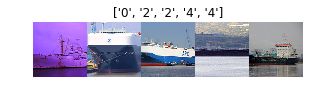

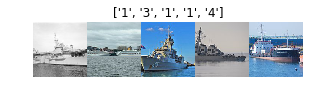

In [0]:
for i in range(4):
    show_batch_images(visloader)

In [0]:
from torchvision import models
from torch.autograd import Variable

In [0]:
resnet = models.resnet50(pretrained=True)

In [0]:
for param in resnet.parameters():
  param.requires_grad=False

In [0]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
num_classes=5

In [0]:
#one way of changing final layer
final_in_features=resnet.fc.in_features
resnet.fc=nn.Linear(final_in_features, num_classes)

In [0]:
print(resnet.fc)

Linear(in_features=2048, out_features=5, bias=True)


In [0]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([5, 2048])
torch.Size([5])


In [0]:
#another way
#final_in_features=vgg.classifier[6].in_features
#mod_classifier=list(vgg.classifier.children())[:-1]  #remove the last layer
#mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
#print(mod_classifier)

In [0]:
bat_size=64

mean=[0.485, 0.456, 0.406]
std_dev=[0.229, 0.224, 0.225]
trans_train=transforms.Compose([transforms.Resize(224),
                                
                         transforms.RandomCrop(224),
                         transforms.RandomHorizontalFlip(),
                         #transforms.RandomRotation(10),       
                         #transforms.Grayscale(num_output_channels=3),       
                         transforms.ToTensor(),
                         transforms.Normalize(mean, std_dev)
                         ])


trans_test=transforms.Compose([transforms.Resize(224),
                         
                         transforms.RandomCrop(224),
                         #transforms.Grayscale(num_output_channels=3),      
                         transforms.ToTensor(),
                         transforms.Normalize(mean, std_dev)
                         ])
trans_val=trans_test

In [0]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
train_split_idx, val_split_idx = next(iter(stratified_split.split(dataframe.image, dataframe.category)))
train_data = dataframe.iloc[train_split_idx].reset_index()
validation_data = dataframe.iloc[val_split_idx].reset_index()

In [0]:
#train_size = int(0.9 * len(dataframe))
#val_size = int(len(dataframe) - train_size)

#train_data, validation_data = torch.utils.data.random_split(dataframe, [train_size, val_size])

In [0]:
train_ds = CustomDataset(train_data,os.path.join(data_root,'images'), transform=trans_train)
print(len(train_ds))

val_ds = CustomDataset(validation_data, os.path.join(data_root, 'images'), transform=trans_val)
print(len(val_ds))

5626
626


In [0]:
test_ds = CustomDataset(test,os.path.join(data_root,'images'), transform=trans_test)
len(test_ds)

2680

In [0]:
trainloader=DataLoader(train_ds, batch_size=bat_size, shuffle=True)
valloader=DataLoader(val_ds, batch_size=bat_size, shuffle=False)
testloader=DataLoader(test_ds, batch_size=bat_size, shuffle=False)

In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
#opt = optim.Adamax(resnet.parameters(), lr=0.01)
opt=optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 0.18
Iteration: 0/1126, Loss: 0.18
Min loss 0.16
Min loss 0.12
Epoch: 0/40, Val acc: 81.63, Train acc: 89.02
Iteration: 0/1126, Loss: 0.29
Epoch: 1/40, Val acc: 82.59, Train acc: 89.37
Iteration: 0/1126, Loss: 0.29
Min loss 0.11
Epoch: 2/40, Val acc: 81.79, Train acc: 89.87
Iteration: 0/1126, Loss: 0.15
Epoch: 3/40, Val acc: 81.79, Train acc: 89.83
Iteration: 0/1126, Loss: 0.24
Min loss 0.11
Epoch: 4/40, Val acc: 82.59, Train acc: 89.05
Iteration: 0/1126, Loss: 0.34
Epoch: 5/40, Val acc: 83.23, Train acc: 89.42
Iteration: 0/1126, Loss: 0.23
Epoch: 6/40, Val acc: 81.47, Train acc: 89.69
Iteration: 0/1126, Loss: 0.30
Epoch: 7/40, Val acc: 84.03, Train acc: 88.98
Iteration: 0/1126, Loss: 0.27
Min loss 0.09
Epoch: 8/40, Val acc: 82.43, Train acc: 89.21
Iteration: 0/1126, Loss: 0.22
Min loss 0.09
Epoch: 9/40, Val acc: 83.39, Train acc: 89.30
Iteration: 0/1126, Loss: 0.29
Epoch: 10/40, Val acc: 83.71, Train acc: 89.25
Iteration: 0/1126, Loss: 0.28
Epoch: 11/40, Val acc: 82.11, Train

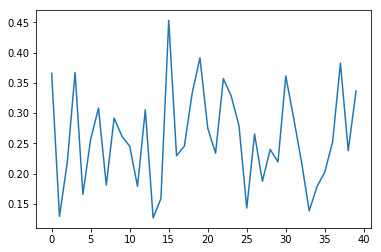

In [129]:
loss_epoch_arr = []
max_epochs = 40
min_loss = 1000

n_iters = np.ceil(len(train_ds)/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):
      
      

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
          min_loss=loss.item()
          best_model_sgd=copy.deepcopy(resnet.state_dict())
          print('Min loss %0.02f' % min_loss)
                  
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Val acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(valloader, resnet),
        evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [130]:
resnet.load_state_dict(best_model_sgd)
print(evaluation(valloader, resnet))
print(evaluation(trainloader, resnet))

84.34504792332268
89.79736935655883


In [0]:
resnet.eval()
with torch.no_grad():
  pred_op=[]
  for inputs, labels in  testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs=Variable(inputs)
    output=resnet(inputs)
    pred = output.data.max(1)[1]
    pred=torch.argmax(output, 1)
    pred=pred.data.cpu().numpy().argmax()
    pred_op.append(pred)
    
    #pred=output.data.numpy().argmax()
    

In [0]:
def pred_image(image):
  resnet.eval()
  torch.no_grad()
  input=Variable(image)
  input=input.to(device)
  output=resnet(input)
  index=output.data.cpu().numpy().argmax()
  return index  
  

In [0]:
!cp sample_submission_ns2btKE.csv submission.csv

In [0]:



def test_submission(model):
  sub_outputs=[]
  output_df=[]
  model.train(False)
  
  for data in testloader:
    inputs, labels=data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    outputs=model(inputs)
    #preds=outputs.data.max(1)[1]
    _, preds=torch.max(outputs.data,1)
    sub_outputs.append(preds.data.cpu().numpy())
    
  sub_outputs=np.concatenate(sub_outputs)
  
  #for idx, row in enumerate(sub_outputs.astype(float)):
  # sub_outputs[idx] = np.exp(row)/np.sum(np.exp(row))
    
  output_df.append(sub_outputs) 
  
  return pd.DataFrame(output_df).T
    
    

In [0]:
s=test_submission(resnet)

In [0]:
submission=pd.concat([test['image'], s], axis=1 )
submission.columns=['image', 'category']

In [0]:
submission['category']=submission['category'].map(lambda x: x+1)

In [138]:
submission.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [0]:
submission.to_csv('submission.csv', index=False)